In [ ]:
import yfinance as yf
import statsmodels.api as sm
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 21.2 COMMON RISK METRICS
In this example, we show how to compute common risk metrics listed in this section:

In [ ]:
# load and check sample data
df_port = yf.download(['XLB', 'XLF', 'XLK', 'XLP', 'XLV'], start='2016-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_port/df_port.shift(1)).dropna()
df_ret.tail()

[*********************100%***********************]  5 of 5 completed


Ticker,XLB,XLF,XLK,XLP,XLV
Date,,,,,
2024-02-22,0.010013,0.011538,0.032199,0.003090,0.011688
2024-02-23,0.005891,0.004975,-0.002335,0.003080,0.004745
2024-02-26,-0.006007,-0.004975,0.000974,-0.004020,-0.005153
2024-02-27,0.003701,0.002739,0.000875,0.000134,-0.002450
2024-02-28,0.003112,0.003723,-0.004727,0.001073,-0.004987


In [ ]:
ret_port = df_ret.mean(axis=1)
eps = 0.05

vol = ret_port.std()*np.sqrt(252)                    # annualized volatility
down_vol = ret_port[ret_port<0].std()*np.sqrt(252)   # annualized downside deviation
VaR = ret_port.quantile(eps)                         # daily VaR
CVaR = ret_port[ret_port<=VaR].mean()                # daily CVaR

print('The annualized volatility is {:.2f}'.format(vol))
print('The annualized downside deviation is {:.2f}'.format(down_vol))
print('The daily VaR volatility is {:.2f}'.format(VaR))
print('The daily CVaR volatility is {:.2f}'.format(CVaR))

The annualized volatility is 0.18
The annualized downside deviation is 0.15
The daily VaR volatility is -0.02
The daily CVaR volatility is -0.03


As we can see above, we start with a return data frame and then compute annualized volaitlity, downside deviation and daily $VaR$ and $CVaR$. The reader should note that the $VaR$ and $CVaR$ quantities are not annualized.  In order to conduct this analysis, we leverage the same return dataset as the efficient frontier example in 19.2.4. The reader should also note that the calculations are based on an equally weighted portfolio, and specify a $5\%$ confidence level for the $VaR$ and $CVaR$ calculations via the variable $\epsilon$.

## 21.3 CALCULATION OF PORTFIOLIO VaR AND CVaR

### 21.3.3 Monte Carlo Simulation
In this example, we define a $VaR$ function that takes a historical returns data frame and a confidence level $\epsilon$. In this function, bootstrapping is used to simulate returns for assets within the portfolio. After generating each new path, we calculate the $VaR$ the same way as we did above.

In [ ]:
def var_boot(df_ret, eps, draws_of_simulation, days_of_silumation):
    '''
    df_ret: dataframe of historical returns
    eps: confidence level
    draws_of_simulation: number of draws simulated from historical returns
    days_of_silumation: number of days of simulation
    '''

    N = df_ret.shape[0]      # number of historical records
    n = df_ret.shape[1]      # number of assets
    ret_simu = np.zeros((draws_of_simulation,n))

    # loop through each draw
    for i in range(draws_of_simulation):

        # randomly pick days_of_silumation out of N historical records
        idx_simu = random.sample(range(N),days_of_silumation)

        # calculate accumulated return over days_of_silumation
        for j in range(days_of_silumation):
            ret_simu[i,:] += df_ret.iloc[idx_simu[j],:]

    df_simu = pd.DataFrame(ret_simu, columns=df_ret.columns)
    df_simu_port = df_simu.mean(axis=1)
    VaR = df_simu_port.quantile(eps)

    return VaR

Note that again we assume an equally weighted portfolio in our $VaR$ calculation.  It should be emphasized that every time we call this function, a new set of return paths will be generated, which results in a new $VaR$ estimate.  Each such estimate is statistically equivalent, but will naturally vary because of the randomness in the simulated paths.  By running the algorithm repeated times, we can get a sense of the distribution of these estimates. For example, the plot below shows the density of $100$ simulated $VaR$'s at a $0.05$ confidence level, using two years of historical ETF data:

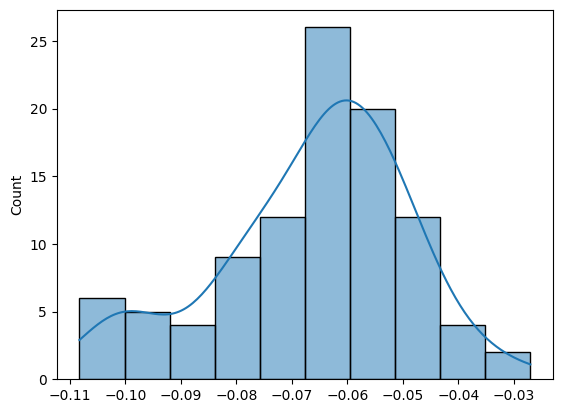

In [ ]:
eps = 0.05
draws_of_simulation = 50     # subject to change
days_of_simulation = 21      # monthly window
var_arr = []
for i in range(100):
    var_arr.append(var_boot(df_ret, eps, draws_of_simulation, days_of_simulation))

sns.histplot(var_arr, kde=True)
plt.show()

*Note: This figure shows one realization of a Monte Carlo simulation; results may vary across runs due to randomness.*

The reader might notice that this distribution of $VaR$ estimates is not as smooth as they might expect.  The reason for this is two-fold.  First, in this example, we bootstrap a daily $VaR$.  This means that each bootstrapped path consists of a single historical return.  A byproduct of this is that the possible set of simulated returns is limited to the historically observed set of returns.  In traditional applications of bootstrapping we would stitch together many returns in the underlying dataset on each bootstrapped path, and this would no longer be the case.  Secondly, in this calculation a relatively short historical window is used, further limiting the set of potential outcomes.  The reader is welcome to relax these assumptions by trying a multi-day $VaR$ or using a longer historical calculation window and experiment with how the distribution of $VaR$ estimates becomes smoother.

### 21.3.6 VaR in Practice: Out of Sample Test of Rolling VaR

The following function `get_rolling_var()` computes rolling $VaR$'s for each individual asset in a given portfolio and for the portfolio. A visualization example of 2-year 5% rolling $VaR$'s is provided for a given set of ETFs:

In [ ]:
def get_rolling_var(ticker, start_date, end_date, win_size, eps):

    assert isinstance(win_size, int), 'Please enter an integer as the window size.'

    # start date for price record
    price_start_date = str((pd.to_datetime(start_date) - pd.DateOffset(years=win_size)).date())
    # start date in the last widow
    last_start_date = str((pd.to_datetime(end_date) - pd.DateOffset(years=win_size) + pd.DateOffset(days=1)).date())

    df_price_full = yf.download(ticker, start=price_start_date, end=end_date, auto_adjust=False)['Adj Close']
    df_ret_full = np.log(df_price_full/df_price_full.shift(1)).dropna()

    VaR_list = []
    VaR_port_list = []

    for date in pd.date_range(price_start_date, last_start_date)[1:]:

        last_date = str((date + pd.DateOffset(years=win_size) - pd.DateOffset(days=1)).date())
        df_ret = df_ret_full.loc[date:last_date]
        df_ret_port = df_ret.mean(axis=1)   # equal-weighted portfolio

        VaR = df_ret.quantile(eps)
        VaR_port = df_ret_port.quantile(eps)

        VaR_list.append(VaR)
        VaR_port_list.append(VaR_port)

    idx = pd.date_range(start_date, end_date, inclusive='left')
    df_VaR = pd.DataFrame(data=VaR_list, index=idx, columns=ticker)
    df_VaR_port = pd.DataFrame(data=VaR_port_list, index=idx, columns=['portfolio'])

    return df_VaR, df_VaR_port

In [ ]:
def plot_rolling_var(df_VaR, df_VaR_port):

    start_date = str(df_VaR.index.min().date())
    end_date = str(df_VaR.index.max().date())

    plt.figure(figsize=(15, 6))
    for tick in df_VaR.columns:
        plt.plot(df_VaR.index, df_VaR[tick].values, label=tick)
    plt.plot(df_VaR_port.index, df_VaR_port['portfolio'].values, linewidth=3, label='portfolio')

    ticks_range = pd.date_range(start_date, end_date, freq='3MS', inclusive='both')
    plt.xticks(ticks_range, [str(dt.year)+'-'+str('%02d'%dt.month) for dt in ticks_range], rotation=90)
    plt.legend()
    plt.show()

[*********************100%***********************]  5 of 5 completed


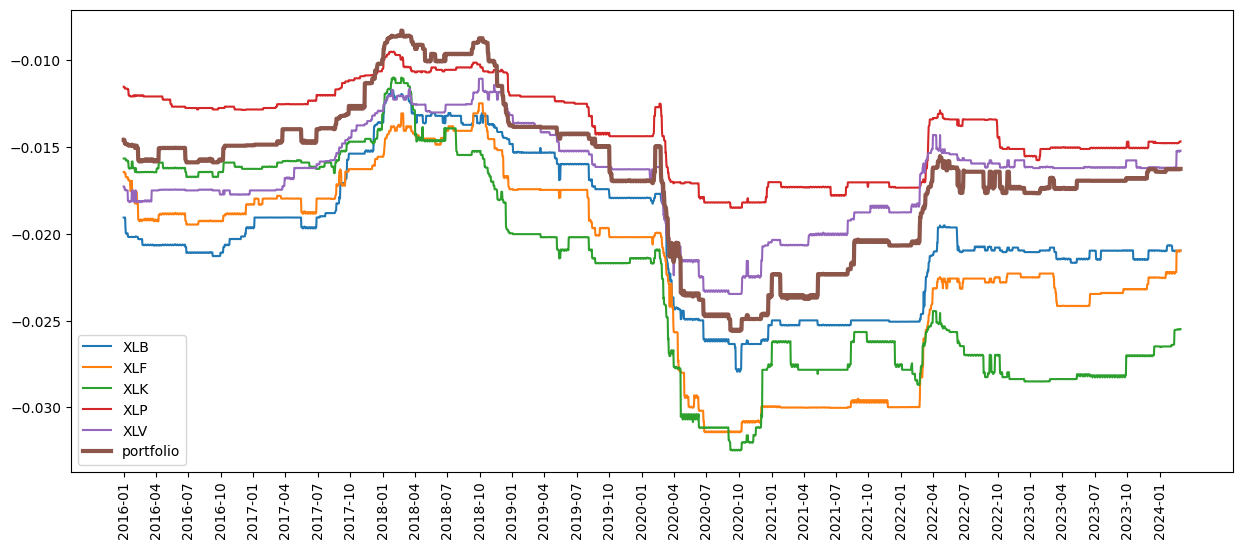

In [ ]:
df_VaR, df_VaR_port = get_rolling_var(ticker = ['XLB', 'XLF', 'XLK', 'XLP', 'XLV'],
                                      start_date = '2016-01-01',
                                      end_date = '2024-02-29',
                                      win_size = 2,
                                      eps = 0.05)
plot_rolling_var(df_VaR, df_VaR_port)

The following function `plot_vars()` plots portfolio rolling estimated $VaR$'s against its one-day forward returns:

In [ ]:
def plot_vars(df_VaR_port, df_ret):

    start_date = str(df_VaR.index.min().date())
    end_date = str(df_VaR.index.max().date())
    port_ret = df_ret.mean(axis=1)

    plt.figure(figsize=(15, 6))
    plt.plot(df_VaR_port.index, df_VaR_port.values.flatten(), linestyle='--', label='historical VaR')
    plt.plot(port_ret.index, port_ret.values, alpha=0.5, label='actual return')

    ticks_range = pd.date_range(start_date, end_date, freq='3MS', inclusive='left')
    plt.xticks(ticks_range, [str(dt.year)+'-'+str('%02d'%dt.month) for dt in ticks_range], rotation=90)
    plt.legend()
    plt.show()

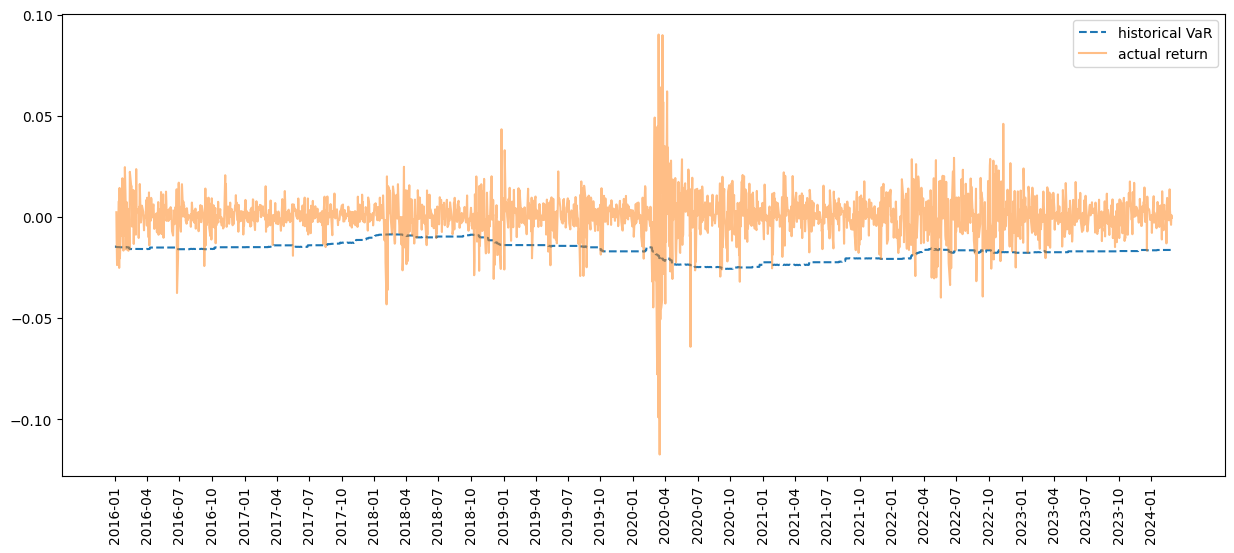

In [ ]:
plot_vars(df_VaR_port, df_ret)

We can further check when the actual return is above or below the historical $VaR$, and compare to what we would theoretially expect given the confidence level:

In [ ]:
df_compare = pd.merge(df_ret.mean(axis=1).to_frame(), df_VaR_port, left_index=True, right_index=True)
df_compare.columns = ['actual', 'historical']
df_compare['if_below'] = df_compare['actual'] < df_compare['historical']
df_compare

,actual,historical,if_below
2016-01-05,0.002393,-0.014767,False
2016-01-06,-0.013206,-0.014767,False
2016-01-07,-0.023727,-0.014834,True
2016-01-08,-0.011348,-0.014834,False
2016-01-11,-0.002388,-0.014836,False
...,...,...,...
2024-02-22,0.013705,-0.016255,False
2024-02-23,0.003271,-0.016255,False
2024-02-26,-0.003836,-0.016276,False
2024-02-27,0.001000,-0.016255,False


In [ ]:
df_compare['if_below'].value_counts().to_frame()

,count
if_below,
False,1950
True,101


In [ ]:
var_breach_rate = df_compare['if_below'].value_counts().values[1]/df_compare.shape[0]
print('The VaR breach rate is {:.3f}%'.format(var_breach_rate*100))

The VaR breach rate is 4.924%


## 21.6.8 Counterparty Risk in Practice: Impact of a Credit Valuation Adjustment on a CDS Contract

Counterparty valuation adjustment (CVA) can be calculated using formula $(22.21)$:

$$CVA = LGD\int_0^T EE^*(t) dPD(0,t)$$

where $LGD$ is the loss given default, $EE^*(t)$ is the discounted expected exposure at time $t$, and $PD(0,t)$ is the probability of default from time $0$ to time $t$. For simplicity, we show a discrete example of CVA calculation using hypothetical credit spreads. Here are the assumptions:

* Risk-free rate: $0.05$
* Notional value: $\$1,000,000$
* Loss given default: $60\%$
* Maturity: $5$ years
* Credit spreads of low, medium, and high default risk:

| Year | Low | Medium | High |
| --- | --- | --- | --- |
| 1 | $1\%$ | $3\%$ | $5\%$ |
| 2 | $1.2\%$ | $3.2\%$ | $5.2\%$ |
| 3 | $1.5\%$ | $3.5\%$ | $5.5\%$ |
| 4 | $1.8\%$ | $3.8\%$ | $5.8\%$ |
| 5 | $2\%$ | $4\%$ | $6\%$ |


In [ ]:
r = 0.05
value = 1000000
lgd = 0.6
spreads = np.array([[0.01, 0.012, 0.015, 0.018, 0.02],     # low
                    [0.03, 0.032, 0.035, 0.038, 0.04],     # medium
                    [0.05, 0.052, 0.055, 0.058, 0.06]])    # high

cva = np.zeros(3)
for i in range(spreads.shape[0]):
    for j in range(spreads.shape[1]):
        ee = value / (1+r)**(i+1)
        pd = spreads[i,j]/lgd
        dcva = lgd*ee*pd
        cva[i] += dcva

print(f'CVA as percentage of notional with low credit spreads: {cva[0]/value*100:.2f}%')
print(f'CVA as percentage of notional with medium credit spreads: {cva[1]/value*100:.2f}%')
print(f'CVA as percentage of notional with high credit spreads: {cva[2]/value*100:.2f}%')

CVA as percentage of notional with low credit spreads: 7.14%
CVA as percentage of notional with medium credit spreads: 15.87%
CVA as percentage of notional with high credit spreads: 23.76%
